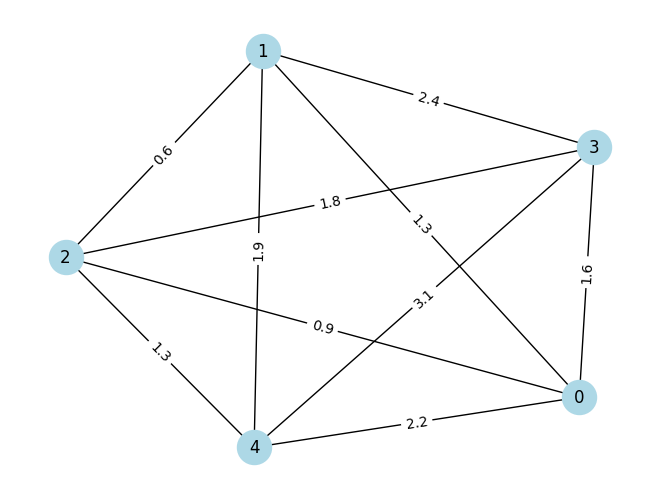

In [1]:
# =============================================================================
# 1) Imports & Problem Definition
# =============================================================================
import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.transpiler import PassManager

# (Optional) If you want to run on IBM hardware:
# from qiskit_ibm_provider import IBMProvider

import matplotlib.pyplot as plt
# =============================================================================
# 1a) Define cities & distances
# =============================================================================
cities = ["A", "B", "C", "D", "E"]
distance_matrix = np.array([
    [0,   1.3, 0.9, 1.6, 2.2],
    [1.3, 0,   0.6, 2.4, 1.9],
    [0.9, 0.6, 0,   1.8, 1.3],
    [1.6, 2.4, 1.8, 0,   3.1],
    [2.2, 1.9, 1.3, 3.1, 0  ]
])

# Build & draw the TSP graph
n = len(cities)
graph = rx.PyGraph()
graph.add_nodes_from(range(n))
for i in range(n):
    for j in range(i+1, n):
        graph.add_edge(i, j, distance_matrix[i][j])

draw_graph(graph, node_size=600, with_labels=True,
           node_color='lightblue',
           edge_labels=lambda w: f"{w:.1f}")
plt.show()


In [2]:
def build_tsp_hamiltonian(graph: rx.PyGraph, penalty: float = 1000) -> SparsePauliOp:
    n = len(graph.nodes())
    terms = []

    # Each city appears exactly once (penalty term)
    for i in range(n):
        base = ["I"] * (n*n)
        for t in range(n):
            base[i*n + t] = "Z"
        terms.append(("".join(base), penalty * (1 - 2/n)))

    # Each timeslot has exactly one city (penalty term)
    for t in range(n):
        base = ["I"] * (n*n)
        for i in range(n):
            base[i*n + t] = "Z"
        terms.append(("".join(base), penalty * (1 - 2/n)))

    # Distance objective: Z_i,t Z_j,(t+1)%n terms weighted by graph weight
    # Use weighted_edge_list() to get (i, j, w)
    for i, j, w in graph.weighted_edge_list():
        for t in range(n):
            base = ["I"] * (n*n)
            base[i*n + t]           = "Z"
            base[j*n + ((t+1) % n)] = "Z"
            terms.append(("".join(base), w / 4))

    return SparsePauliOp.from_list(terms)


In [3]:
tsp_hamiltonian = build_tsp_hamiltonian(graph)
print("Built Hamiltonian with", len(tsp_hamiltonian), "Pauli terms")


Built Hamiltonian with 60 Pauli terms


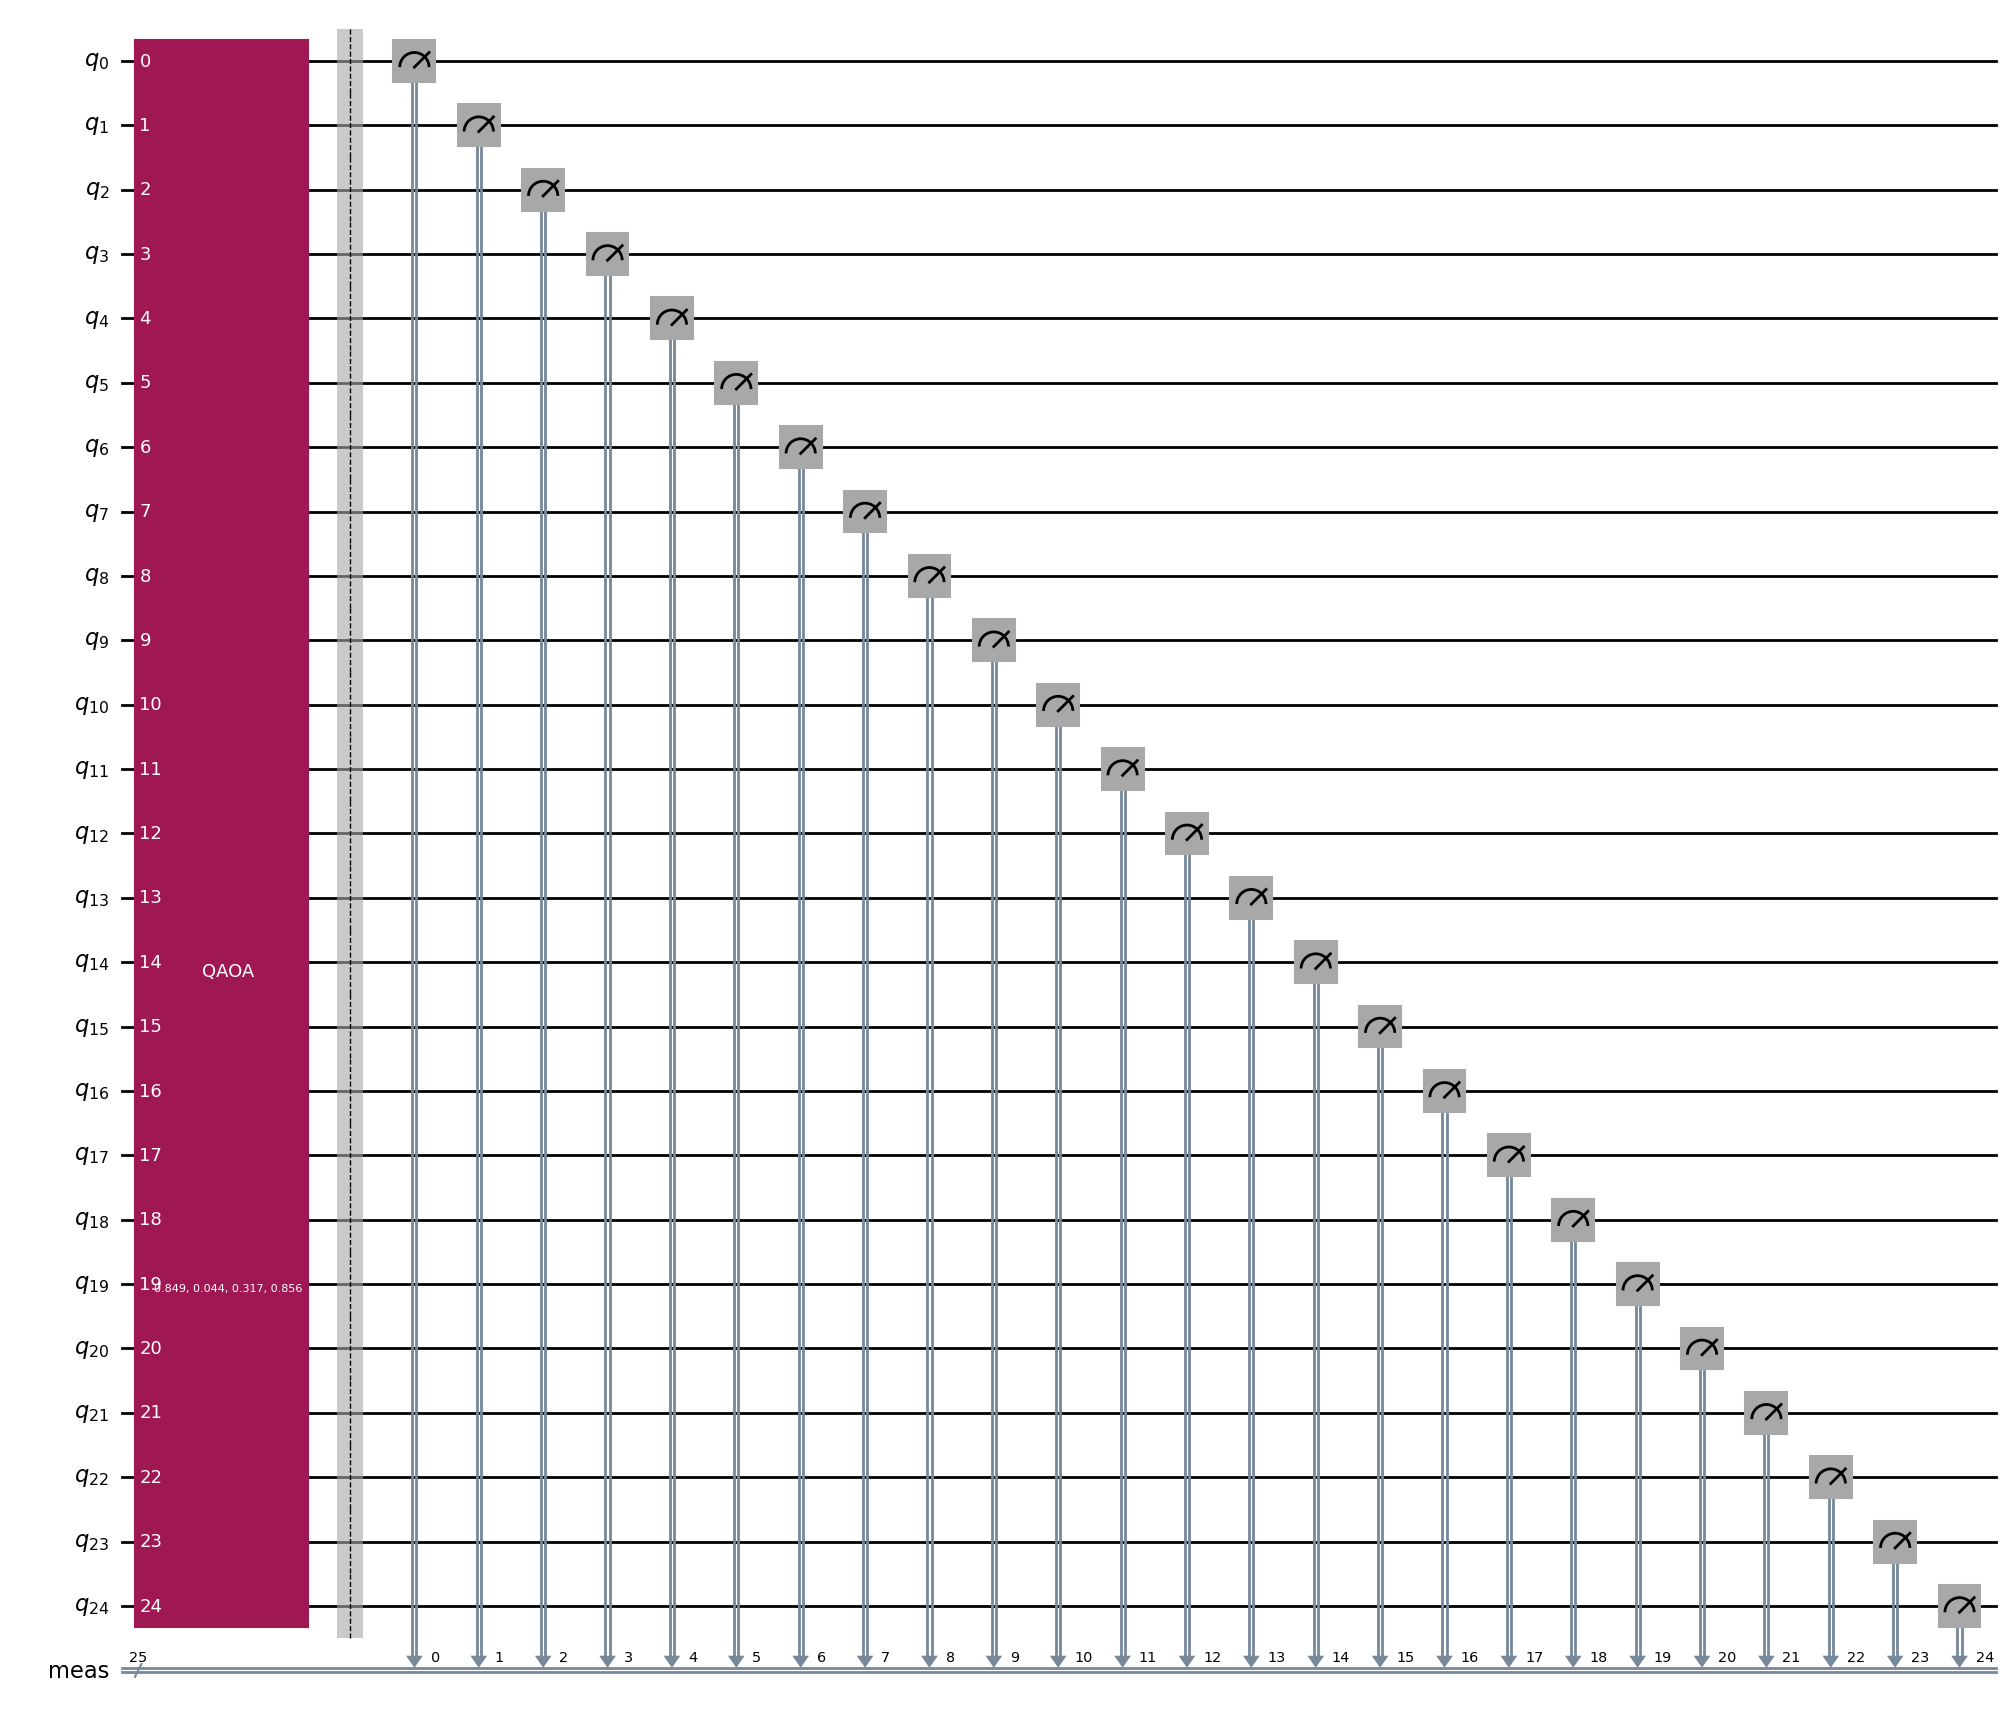

In [4]:
# =============================================================================
# 3) QAOA Circuit Construction
# =============================================================================
reps = 2
qaoa = QAOAAnsatz(cost_operator=tsp_hamiltonian, reps=reps)

# 3a) Option 1: random initial angles → full circuit with measurements
init_angles = np.random.rand(qaoa.num_parameters)
qc = qaoa.assign_parameters(init_angles, inplace=False)
qc.measure_all()

# Draw the circuit (this may be large!)
qc.draw("mpl", fold=-1)


In [30]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService


In [31]:
# Select least busy backend
dev = service.least_busy(min_num_qubits=5, simulator=False, operational=True)
print(dev)

<IBMBackend('ibm_brisbane')>


In [32]:
seed_sim = 42
noisy_fake_backend = AerSimulator.from_backend(dev, seed_simulator=seed_sim)
print(noisy_fake_backend)


AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['id', 'x', 'ecr', 'measure', 'reset', 'sx']>)


In [34]:
pm = generate_preset_pass_manager(backend=noisy_fake_backend, optimization_level=2)
isa_circuit = pm.run(qc) 

In [35]:
isa_circuit.draw("mpl", idle_wires=False)


In [15]:
# Threshold values for noise filtering
max_readout_error = 0.05      # Maximum allowed readout error (5%)
max_single_gate_error = 0.01  # Maximum allowed single-qubit gate error (1%)
max_cx_error = 0.03           # Maximum allowed CX gate error (3%)


In [16]:

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

service = QiskitRuntimeService()
dev = service.least_busy(min_num_qubits=5, simulator=False, operational=True)
seed_sim = 42

# Create a noisy simulator that mimics the real device
noisy_fake_backend = AerSimulator.from_backend(dev, seed_simulator=seed_sim)

#from qiskit.visualization import plot_error_map
#plot_error_map(noisy_fake_backend, figsize=(30, 24))
Noise_dict = dict()
backend_name = noisy_fake_backend.name
num_qubits = noisy_fake_backend.num_qubits
cmap = noisy_fake_backend.coupling_map
two_q_error_map = {}
single_gate_errors = [0] * num_qubits
read_err = [0] * num_qubits
cx_errors = []
for gate, prop_dict in noisy_fake_backend.target.items():
    if prop_dict is None or None in prop_dict:
        continue
    for qargs, inst_props in prop_dict.items():
        if inst_props is None:
            continue
        if gate == "measure":
            if inst_props.error is not None:
                read_err[qargs[0]] = inst_props.error
                Noise_dict[f"{qargs[0]}"] = inst_props.error
        elif len(qargs) == 1:
            if inst_props.error is not None:
                single_gate_errors[qargs[0]] = max(
                    single_gate_errors[qargs[0]], inst_props.error
                )
        elif len(qargs) == 2:
            if inst_props.error is not None:
                two_q_error_map[qargs] = max(two_q_error_map.get(qargs, 0), inst_props.error)
len(read_err)
Noise_dict


C:\Users\abhis\AppData\Local\Temp\ipykernel_50588\601423626.py:4: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


{'0': 0.011962890625,
 '1': 0.09619140625,
 '2': 0.137451171875,
 '3': 0.029296875,
 '4': 0.014404296875,
 '5': 0.04296875,
 '6': 0.087890625,
 '7': 0.12646484375,
 '8': 0.071533203125,
 '9': 0.099853515625,
 '10': 0.011474609375,
 '11': 0.011474609375,
 '12': 0.047119140625,
 '13': 0.02587890625,
 '14': 0.017822265625,
 '15': 0.05419921875,
 '16': 0.138916015625,
 '17': 0.019775390625,
 '18': 0.025634765625,
 '19': 0.030517578125,
 '20': 0.0791015625,
 '21': 0.067626953125,
 '22': 0.09765625,
 '23': 0.107666015625,
 '24': 0.075439453125,
 '25': 0.02880859375,
 '26': 0.004638671875,
 '27': 0.016357421875,
 '28': 0.0576171875,
 '29': 0.007568359375,
 '30': 0.01611328125,
 '31': 0.011474609375,
 '32': 0.012939453125,
 '33': 0.10302734375,
 '34': 0.067626953125,
 '35': 0.033935546875,
 '36': 0.010986328125,
 '37': 0.024169921875,
 '38': 0.027099609375,
 '39': 0.029052734375,
 '40': 0.006103515625,
 '41': 0.002197265625,
 '42': 0.0517578125,
 '43': 0.014404296875,
 '44': 0.0126953125,
 '45

In [17]:
# Identify good qubits based on both readout and single-qubit gate error
good_qubits = [
    q for q in range(num_qubits)
    if read_err[q] <= max_readout_error and single_gate_errors[q] <= max_single_gate_error
]
print("Good qubits:", good_qubits)


Good qubits: [0, 3, 4, 5, 10, 11, 12, 13, 14, 17, 18, 19, 25, 26, 27, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]


In [18]:
# Identify good 2-qubit edges (for CX)
good_cx_edges = [
    q for q, err in two_q_error_map.items()
    if err <= max_cx_error and q[0] in good_qubits and q[1] in good_qubits
]
print("Good CX edges:", good_cx_edges)


Good CX edges: [(4, 3), (5, 4), (10, 11), (11, 12), (12, 13), (14, 0), (14, 18), (17, 12), (17, 30), (18, 19), (26, 25), (26, 27), (29, 30), (31, 30), (31, 32), (32, 36), (35, 47), (36, 51), (37, 38), (38, 39), (40, 39), (41, 40), (43, 44), (45, 44), (45, 46), (47, 46), (47, 48), (49, 48), (49, 50), (50, 51), (52, 37), (54, 45), (55, 49), (57, 58), (61, 60), (61, 62), (63, 62), (66, 65), (67, 66), (68, 55), (68, 67), (69, 68), (69, 70), (71, 58), (71, 77), (73, 66), (73, 85), (74, 70), (77, 76), (78, 77), (78, 79), (79, 91), (80, 79), (80, 81), (81, 82), (82, 83), (86, 85), (86, 87), (87, 88), (89, 74), (89, 88), (90, 94), (92, 83), (92, 102), (95, 94), (95, 96), (97, 96), (97, 98), (98, 91), (99, 98), (99, 100), (101, 100), (101, 102), (102, 103), (104, 103), (105, 104), (106, 105), (107, 106), (107, 108), (109, 96), (110, 100), (110, 118), (111, 104), (112, 108), (112, 126), (113, 114), (114, 109), (117, 116), (117, 118), (119, 118), (119, 120), (120, 121), (121, 122), (122, 111), (1

In [19]:
from qiskit.transpiler import CouplingMap

filtered_coupling_map = CouplingMap(good_cx_edges)


In [21]:
print(noisy_fake_backend.configuration().coupling_map)


[(1, 0), (1, 2), (3, 2), (4, 3), (4, 15), (5, 4), (6, 5), (7, 6), (7, 8), (8, 9), (10, 9), (10, 11), (11, 12), (12, 13), (14, 0), (14, 18), (16, 8), (17, 12), (17, 30), (18, 19), (19, 20), (20, 33), (21, 20), (21, 22), (22, 15), (23, 22), (23, 24), (25, 24), (26, 16), (26, 25), (26, 27), (28, 27), (29, 28), (29, 30), (31, 30), (31, 32), (32, 36), (33, 39), (34, 24), (35, 28), (35, 47), (36, 51), (37, 38), (38, 39), (40, 39), (41, 40), (41, 53), (42, 41), (43, 34), (43, 42), (43, 44), (45, 44), (45, 46), (47, 46), (47, 48), (49, 48), (49, 50), (50, 51), (52, 37), (53, 60), (54, 45), (55, 49), (56, 52), (56, 57), (57, 58), (59, 58), (59, 60), (61, 60), (61, 62), (63, 62), (63, 64), (64, 54), (64, 65), (66, 65), (67, 66), (68, 55), (68, 67), (69, 68), (69, 70), (71, 58), (71, 77), (72, 62), (73, 66), (73, 85), (74, 70), (75, 76), (77, 76), (78, 77), (78, 79), (79, 91), (80, 79), (80, 81), (81, 72), (81, 82), (82, 83), (83, 84), (85, 84), (86, 85), (86, 87), (87, 88), (89, 74), (89, 88), (